# Analyzing EURO-CORDEX Climate Indicators

We will open the climdex catalog and make a plot of all available `TG` indices for historical and scenario time periods. We use a dask scheduler to speed up the processing. This notebook is loosely based on the [CMIP6 global temperature pangeo example](http://gallery.pangeo.io/repos/pangeo-gallery/cmip6/global_mean_surface_temp.html).

In [1]:
from matplotlib import pyplot as plt
import xarray as xr
import numpy as np
import dask
from dask.diagnostics import progress
from tqdm.autonotebook import tqdm 
import intake
import fsspec
import seaborn as sns
import pandas as pd
import xclim

%matplotlib inline
%config InlineBackend.figure_format = 'retina'

/tmp/ipykernel_12609/766847821.py:6: TqdmExperimentalWarning: Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)
  from tqdm.autonotebook import tqdm


In [2]:
from dask.distributed import Client
client = Client()
client

distributed.diskutils - INFO - Found stale lock file and directory '/mnt/lustre01/pf/zmaw/g300046/python/notebooks/dask-worker-space/worker-6747mnwd', purging
distributed.diskutils - INFO - Found stale lock file and directory '/mnt/lustre01/pf/zmaw/g300046/python/notebooks/dask-worker-space/worker-5isbewnq', purging
distributed.diskutils - INFO - Found stale lock file and directory '/mnt/lustre01/pf/zmaw/g300046/python/notebooks/dask-worker-space/worker-dsdtgd69', purging
distributed.diskutils - INFO - Found stale lock file and directory '/mnt/lustre01/pf/zmaw/g300046/python/notebooks/dask-worker-space/worker-jlw954x9', purging
distributed.diskutils - INFO - Found stale lock file and directory '/mnt/lustre01/pf/zmaw/g300046/python/notebooks/dask-worker-space/worker-gd__vm85', purging
distributed.diskutils - INFO - Found stale lock file and directory '/mnt/lustre01/pf/zmaw/g300046/python/notebooks/dask-worker-space/worker-__0ihjdq', purging
distributed.diskutils - INFO - Found stale loc

Connection method: Cluster object,Cluster type: distributed.LocalCluster
Dashboard: /user/g300046/advanced//proxy/8787/status,
Dashboard: /user/g300046/advanced//proxy/8787/status,Workers: 8
Total threads: 48,Total memory: 60.94 GiB
Status: running,Using processes: True
Comm: tcp://127.0.0.1:38023,Workers: 8
Dashboard: /user/g300046/advanced//proxy/8787/status,Total threads: 48
Started: Just now,Total memory: 60.94 GiB
Comm: tcp://127.0.0.1:33014,Total threads: 6
Dashboard: /user/g300046/advanced//proxy/33079/status,Memory: 7.62 GiB
Nanny: tcp://127.0.0.1:45777,


## Access data

Now we can open the catalog file and make a quick overview of the content...

In [3]:
import intake
%matplotlib
url = "/mnt/lustre02/work/ch0636/eddy/pool/intake-esm_catalogues/climdexCORDEX.json"
cat = intake.open_esm_datastore(url)
cat

Using matplotlib backend: <object object at 0x2ac809759e90>


,unique
product_id,1
CORDEX_domain,1
activity_id,0
institution_id,2
source_id,15
experiment_id,4
driving_model_id,11
rcm_version_id,4
member_id,4
table_id,1


In [4]:
# check out which indices are available...
cat.unique()['variable_id']

{'count': 26,
 'values': ['FG',
  'DSP',
  'R25mm',
  'FDD',
  'GD5',
  'SQI',
  'RR95p',
  'R5mm',
  'R10mm',
  'RRm',
  'TR',
  'FD',
  'CHDX30',
  'DSPx',
  'TG',
  'RR1',
  'R15mm',
  'DD',
  'HD17',
  'SU',
  'RR99p',
  'CWB',
  'R20mm',
  'SU30',
  'ID',
  'HI']}

In [5]:
cat.unique()['version']

{'count': 2,
 'values': ['climdex-v2-0',
  'Climate Data Operators version 1-9-8 (https://mpimet-mpg-de/cdo)']}

Now let's get a subset of the data. We want the `TG` index and for all experiment ids.

In [6]:
pd.set_option('display.max_rows', None)
#version = 'Climate Data Operators version 1-9-8 (https://mpimet-mpg-de/cdo)'
version = 'climdex-v2-0'
expts = ['historical', 'rcp26', 'rcp45', 'rcp85']
# require_all_on means we want only those models for which all experiment ids are available.
subset = cat.search(variable_id='TG', frequency='year', version=version, require_all_on='source_id')

subset.df.groupby(["source_id", "driving_model_id", "institution_id", "experiment_id"]
                 )["experiment_id"].nunique()

source_id                     driving_model_id       institution_id  experiment_id
CLMcom-BTU-CCLM4-8-17         MPI-M-MPI-ESM-LR       GERICS          rcp26            1
CLMcom-CCLM4-8-17             CCCma-CanESM2          GERICS          rcp85            1
                              CNRM-CERFACS-CNRM-CM5  GERICS          rcp45            1
                                                                     rcp85            1
                              ECMWF-ERAINT           GERICS          evaluation       1
                              ICHEC-EC-EARTH         GERICS          rcp26            1
                                                                     rcp45            1
                                                                     rcp85            1
                              MIROC-MIROC5           GERICS          rcp26            1
                                                                     rcp85            1
                              MOHC-Ha

In [7]:
dset_dict = subset.to_dataset_dict(cdf_kwargs = {"use_cftime": True, "chunks": {}})


--> The keys in the returned dictionary of datasets are constructed as follows:
	'CORDEX_domain.institution_id.source_id.driving_model_id.experiment_id.member_id.table_id'


In [9]:
ds = dset_dict["EUR-11.GERICS.GERICS-REMO2015.IPSL-IPSL-CM5A-LR.rcp26.r1i1p1.day"]
#ds = dset_dict['EUR-11.GERICS.SMHI-RCA4.ICHEC-EC-EARTH.rcp85.r12i1p1.day']
ds

<xarray.Dataset>
Dimensions:                     (time: 152, bnds: 2, rlat: 412, rlon: 424, vertices: 4)
Coordinates:
  * time                        (time) object 1949-07-02 12:00:00 ... 2100-07...
    lon                         (rlat, rlon) float32 dask.array<chunksize=(412, 424), meta=np.ndarray>
    lat                         (rlat, rlon) float32 dask.array<chunksize=(412, 424), meta=np.ndarray>
  * rlon                        (rlon) float64 -28.38 -28.27 ... 18.04 18.16
  * rlat                        (rlat) float64 -23.38 -23.27 ... 21.72 21.84
    height                      float64 ...
Dimensions without coordinates: bnds, vertices
Data variables:
    time_bnds                   (time, bnds) object dask.array<chunksize=(152, 2), meta=np.ndarray>
    lon_bnds                    (rlat, rlon, vertices) float32 dask.array<chunksize=(412, 424, 4), meta=np.ndarray>
    lat_bnds                    (rlat, rlon, vertices) float32 dask.array<chunksize=(412, 424, 4), meta=np.ndarray>
    rotated_latitude_longitude  int32 ...
    TG                          (time, rlat, rlon) float32 dask.array<chunksize=(152, 412, 424), meta=np.ndarray>
Attributes: (12/42)
    history:                        Tue May 04 10:41:05 2021: cdo -O -f nc4 -...
    source:                         GERICS-REMO2015
    institution:                    Helmholtz-Zentrum Geesthacht, Climate Ser...
    Conventions:                    CF-1.4
    institute_id:                   GERICS
    experiment_id:                  historical
    ...                             ...
    ci_frequency:                   year
    ci_timerange_index:             1949-2100
    ci_timerange_source:            19480102-21001231
    ci_package_reference:           Climate Data Operators version 1.9.8 (htt...
    intake_esm_varname:             ['TG']
    intake_esm_dataset_key:         EUR-11.GERICS.GERICS-REMO2015.IPSL-IPSL-C...

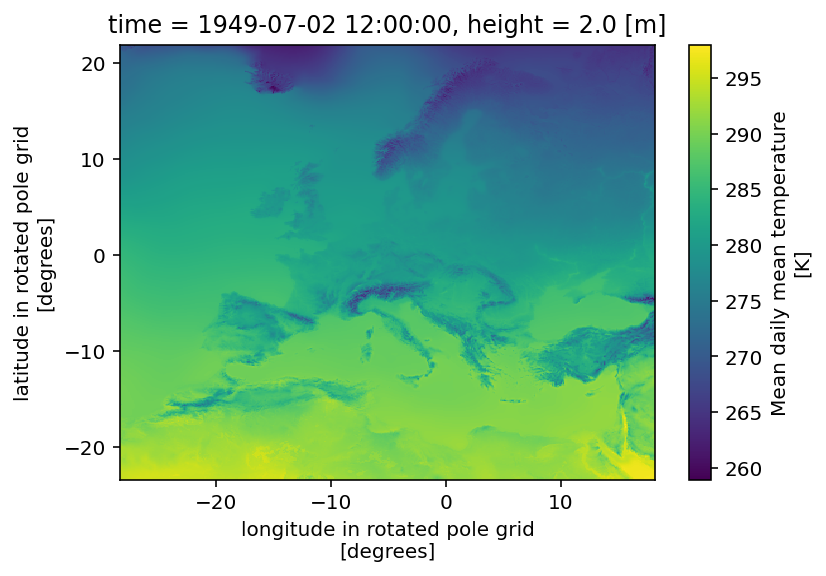

In [10]:
%matplotlib inline
ds.TG.isel(time=0).plot()

## Data preparation

The CORDEX datasets are not really all that CF compliant as they should be. They also have different calendars and coordinates. We have to [prepare the data](https://en.wikipedia.org/wiki/Data_preparation) to make the different models comparable. Lets first define some helper functions.

In [49]:
# experimentel cordex module that deals with CORDEX datasets
from cordex import preprocessing as preproc
from cftime import datetime as dt

def drop_all_bounds(ds):
    """Drops boundaries"""
    drop_vars = [vname for vname in ds
                 if (('bounds') in vname ) or ('bnds') in vname]
    return ds.drop(drop_vars).squeeze(drop=True)

def get_experiment_from_id(dset_id):
    """Return the experiment id from the dataset id"""
    return dset_id.split(".")[4]

Now, we do the actual data alignment. We drop boundaries, filter rotated pole models, set coordinates and use one common calendar.

In [50]:
# drop boundaries since they have different names in the different models.
dset_dict_preproc = {key: drop_all_bounds(preproc.rename_cordex(ds)) for key, ds in dset_dict.items()}

# only use rotated pole models for now.
rotated = {key: ds for key, ds in dset_dict_preproc.items() if preproc.get_grid_mapping_name(ds) == 'rotated_latitude_longitude'}

# replace coordinates with official archive specifications.
rotated = {key: preproc.replace_coords(ds) for key, ds in rotated.items()}

# replace calendars with standard gregorian since we only use monthly or yearly frequencies anyway.
for dset_id, ds in rotated.items():
    ds['time'] = [dt(date.year, 1, 1) for date in ds.time.values]

In [67]:
ds = rotated['EUR-11.GERICS.KNMI-RACMO22E.CNRM-CERFACS-CNRM-CM5.rcp26.r1i1p1.day']
ds

<xarray.Dataset>
Dimensions:                     (time: 151, rlat: 412, rlon: 424)
Coordinates:
  * time                        (time) object 1950-01-01 00:00:00 ... 2100-01...
  * rlon                        (rlon) float64 -28.38 -28.27 ... 18.05 18.16
  * rlat                        (rlat) float64 -23.38 -23.27 ... 21.73 21.84
    lon                         (rlat, rlon) float64 -10.06 -9.964 ... 64.96
    lat                         (rlat, rlon) float64 21.99 22.03 ... 66.75 66.69
Data variables:
    rotated_latitude_longitude  int32 ...
    height                      float64 ...
    TG                          (time, rlat, rlon) float32 dask.array<chunksize=(151, 412, 424), meta=np.ndarray>
Attributes: (12/39)
    history:                        Tue May 04 06:52:44 2021: cdo -O -f nc4 -...
    institution:                    Royal Netherlands Meteorological Institute
    Conventions:                    CF-1.4
    contact:                        Erik van Meijgaard, KNMI, Regional Climat...
    experiment:                     Historical run
    experiment_id:                  historical
    ...                             ...
    ci_frequency:                   year
    ci_timerange_index:             1950-2100
    ci_timerange_source:            19500101-21001231
    ci_package_reference:           Climate Data Operators version 1.9.8 (htt...
    intake_esm_varname:             ['TG']
    intake_esm_dataset_key:         EUR-11.GERICS.KNMI-RACMO22E.CNRM-CERFACS-...

Now, we sort the datasets depending on their `experiment_id` attribute. This is useful, since there are many more `rcp85` than `rcp26` or `rcp45` datasets available and we can handle those separately.

In [68]:
from collections import defaultdict
dsets_sorted = defaultdict(dict)

for dset_id, ds in rotated.items():
    dsets_sorted[get_experiment_from_id(dset_id)][dset_id] = ds

# count numbers
print(dsets_sorted.keys())
for exp_id, dsets in dsets_sorted.items():
    print('found {} datasets for {}'.format(len(dsets), exp_id))

dict_keys(['rcp26', 'rcp85', 'rcp45', 'evaluation'])
found 26 datasets for rcp26
found 65 datasets for rcp85
found 23 datasets for rcp45
found 9 datasets for evaluation


### Create ensemble datasets

In [69]:
ensemble_dict = {}

for exp_id, dsets in dsets_sorted.items():
    print(exp_id)
    ensemble = xr.concat(list(dsets_sorted[exp_id].values()), dim='dset_id')
    ensemble['dset_id'] = list(dsets_sorted[exp_id].keys())
    ensemble_dict[exp_id] = ensemble

rcp26
rcp85


MergeError: conflicting values for variable 'height' on objects to be combined. You can skip this check by specifying compat='override'.

Ok, there was a problem with combining the datasets because they have different values for the `height` coordinate. Let's investigate this:

In [75]:
for dset_id, ds in dsets_sorted['rcp85'].items():
    if 'height' in ds:
        print(dset_id, ds.height.values)
    else:
        print(dset_id, 'unknown')

EUR-11.GERICS.IPSL-WRF381P.MOHC-HadGEM2-ES.rcp85.r1i1p1.day unknown
EUR-11.GERICS.DMI-HIRHAM5.NCC-NorESM1-M.rcp85.r1i1p1.day 2.0
EUR-11.GERICS.SMHI-RCA4.MOHC-HadGEM2-ES.rcp85.r1i1p1.day 2.0
EUR-11.GERICS.UHOH-WRF361H.MOHC-HadGEM2-ES.rcp85.r1i1p1.day 2.0
EUR-11.GERICS.CLMcom-CCLM4-8-17.CCCma-CanESM2.rcp85.r1i1p1.day 2.0
EUR-11.GERICS.GERICS-REMO2015.ICHEC-EC-EARTH.rcp85.r12i1p1.day 2.0
EUR-11.GERICS.CLMcom-ETH-COSMO-crCLIM-v1-1.MPI-M-MPI-ESM-LR.rcp85.r2i1p1.day 2.0
EUR-11.GERICS.CLMcom-ETH-COSMO-crCLIM-v1-1.ICHEC-EC-EARTH.rcp85.r12i1p1.day 2.0
EUR-11.GERICS.KNMI-RACMO22E.NCC-NorESM1-M.rcp85.r1i1p1.day 2.0
EUR-11.GERICS.DMI-HIRHAM5.ICHEC-EC-EARTH.rcp85.r3i1p1.day 2.0
EUR-11.GERICS.KNMI-RACMO22E.IPSL-IPSL-CM5A-MR.rcp85.r1i1p1.day 2.0
EUR-11.GERICS.DMI-HIRHAM5.ICHEC-EC-EARTH.rcp85.r12i1p1.day 2.0
EUR-11.GERICS.DMI-HIRHAM5.MPI-M-MPI-ESM-LR.rcp85.r1i1p1.day 2.0
EUR-11.GERICS.CLMcom-ETH-COSMO-crCLIM-v1-1.MOHC-HadGEM2-ES.rcp85.r1i1p1.day 2.0
EUR-11.GERICS.MOHC-HadREM3-GA7-05.MOHC-HadGEM2-ES.rc

We can see that there are different values for `height`. Some datasets don't even define that coordinate. However, we can just ignore this by setting the `compat`, `coords` and `data_vars` keyword appropriately in `xr.concat`. Still, it's important to keep in mind that we ignored these inconsistencies.

In [76]:
ensemble_dict = {}

for exp_id, dsets in dsets_sorted.items():
    ensemble = xr.concat(list(dsets_sorted[exp_id].values()), dim='dset_id', compat='override', coords='minimal', data_vars='minimal')
    ensemble['dset_id'] = list(dsets_sorted[exp_id].keys())
    ensemble_dict[exp_id] = ensemble

Now, we are only left with three ensemble datasets that we can now easily analyze. Note, that we have made the dataset ids which where keys in our dictionary before into a coordinate of a dataset. That means that we can do *all* analysis now for *all* models without having to think about the inconsistencies anymore and let xarray do the [parallelization an vectorization](https://examples.dask.org/xarray.html). We can also now do cross model computations easily (e.g. min, max, mean, etc...).

In [80]:
ensemble_dict.keys()

for exp_id, ens in ensemble_dict.items():
    print('found {} datasets for {}'.format(len(ens.dset_id), exp_id))

found 26 datasets for rcp26
found 65 datasets for rcp85
found 23 datasets for rcp45
found 9 datasets for evaluation


In [ ]:
## Data analysis